In [21]:
import json
import os
import pickle

import numpy as np
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches


from evaluate_util import get_model, plot_model_output
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [22]:
experiments_of_interest = ["2024_07_19__08_14_46_eval_test_standard", "2024_07_18__07_11_32_eval_test"]
experiments_labels = ["baseline", "cdr 10, stretch 0.5", "topological loss, very narrow"]
experiments_colors = [("b", "cornflowerblue"), ("green", "limegreen"), ("orangered", "coral")]
exp_paths = ["experiments/" + name for name in experiments_of_interest]

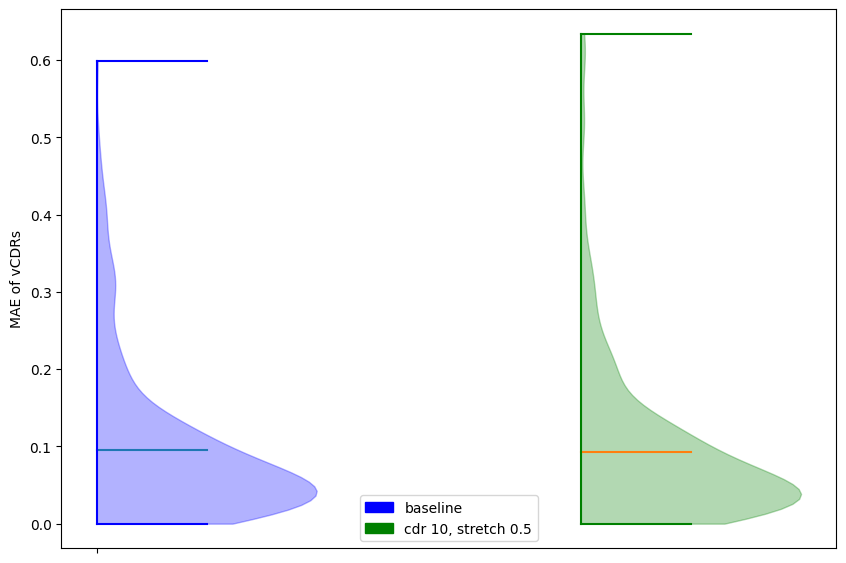

In [30]:
patches = []
labels = []
width = 0.1
shift_factor = width*1.1

fig = plt.figure()
ax = fig.add_subplot()

for i in range(len(experiments_of_interest)):
    with open(exp_paths[i] + "/diameters.pickle", "rb") as handle:
        diameters = pickle.load(handle)

    cdr_label = [diameters["label"][0][i] / diameters["label"][1][i] for i in range(len(diameters["label"][0]))]
    cdr_pred = [diameters["pred"][0][i] / diameters["pred"][1][i] for i in range(len(diameters["label"][0]))]
    data = [abs(cdr_pred[i] - cdr_label[i]) for i in range(len(cdr_pred))]
    violin = ax.violinplot(data,
                            positions = [0 + shift_factor*i],
                            widths=width,
                            showmeans=True,
                            side="high")

    for pc in violin['bodies']:
        pc.set_facecolor(experiments_colors[i][0])
        pc.set_edgecolor(experiments_colors[i][0])
    for partname in ('cbars','cmins','cmaxes'):
        vp = violin[partname]
        vp.set_edgecolor(experiments_colors[i][0])
    patches.append(mpatches.Patch(color=experiments_colors[i][0]))
    labels.append(experiments_labels[i])

ax.set_xticks([0], [""])
plt.ylabel("MAE of vCDRs")
plt.legend(patches, labels, loc=8) # loc 4 ... lower center
plt.show()

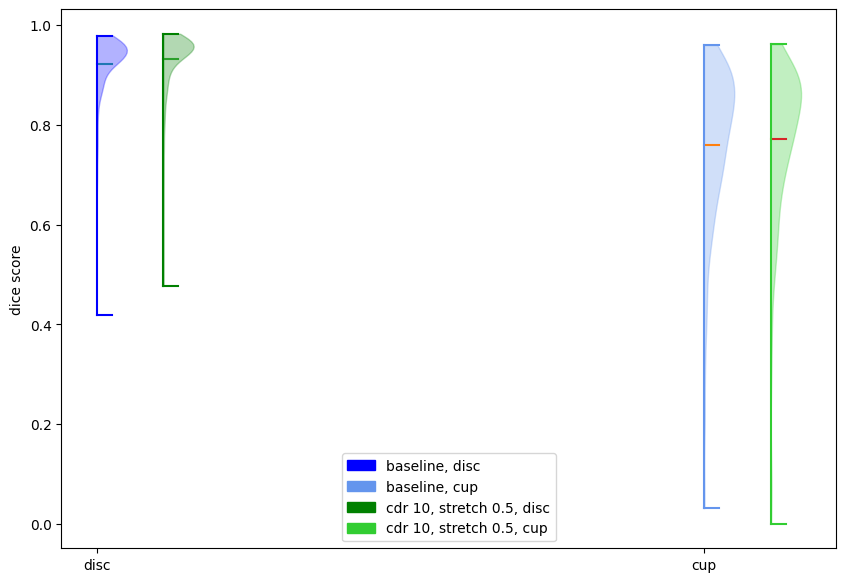

In [29]:
patches = []
labels = []
width = 0.1
shift_factor = width*1.1

fig = plt.figure()
ax = fig.add_subplot()

for i in range(len(experiments_of_interest)):
    with open(exp_paths[i] + "/dice.pickle", "rb") as handle:
        data = pickle.load(handle)

    violin = ax.violinplot(data[1],
                            positions = [0 + shift_factor*i],
                            widths=width,
                            showmeans=True,
                            side="high")

    for pc in violin['bodies']:
        pc.set_facecolor(experiments_colors[i][0])
        pc.set_edgecolor(experiments_colors[i][0])
    for partname in ('cbars','cmins','cmaxes'):
        vp = violin[partname]
        vp.set_edgecolor(experiments_colors[i][0])
    patches.append(mpatches.Patch(color=experiments_colors[i][0]))
    labels.append(experiments_labels[i] + ", disc")

    violin = ax.violinplot(data[0],
                            positions = [1 + i*shift_factor],
                            widths=width,
                            showmeans=True,
                            side="high")
    for pc in violin['bodies']:
        pc.set_facecolor(experiments_colors[i][1])
        pc.set_edgecolor(experiments_colors[i][1])
    for partname in ('cbars','cmins','cmaxes'):
        vp = violin[partname]
        vp.set_edgecolor(experiments_colors[i][1])
    patches.append(mpatches.Patch(color=experiments_colors[i][1]))
    labels.append(experiments_labels[i] + ", cup")
ax.set_xticks([0, 1], ["disc", "cup"])
plt.ylabel("dice score")
plt.legend(patches, labels, loc=8) # loc 4 ... lower center
plt.show()